# CIC Current System Network Graph

# Graph overview 

Modeling as a weighted directed graph with agents as nodes. A network is a set of items (nodes or vertices) connected by edges or links. 
We represent a network by a graph (N, g), which consists of a set of nodes N = {1, . . . , n}.

#### Node types
* Agent

An agent is a user of the CIC system.
* Chama

A chama is a savings group consisting of multiple agents. Redemptions of CICs for fiat occur through chamas.
* Trader

A trader is an agent interacting with the bonding curve for investment/arbitrage opportunities.
* Cloud

The cloud is a representation of the open boundary to the world external to the model.
* Contract

The contract is the smart contract of the bonding curve.

### Edges between agents
The edge weight gij > 0 takes on non-binary values, representing the intensity of the interaction, so we refer to (N, g) as a weighted graph.
E is the set of “directed” edges, i.e., (i, j) ∈ E

#### Edge types
* Demand
* Fraction of demand in CIC
* Utility - stack ranking. Food/Water is first, shopping, etc farther down
* Spend
* Fraction of actual in CIC

![](images/dualoperator.png)


![](images/v3differentialspec.png)

## Assumptions
(Defining data structures, not just initialization. Baking in degrees of freedom for future experimentation)

* agents = a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p
* Agent starting native currency is picked from a uniform distribution with a range of 20 to 500. Starting tokens is 400.
* system = external,cic
* chama = chama_1,chama_2,chama_3,chama_4

Chamas are currently set to zero, it can be configured for more detailed analysis later on.
* traders = ta,tb,tc

Traders are currently set to zero, it can be configured for more detailed analysis later on.
* Utility Types Ordered:
 * Food/Water
 * Fuel/Energy
 * Health
 * Education
 * Savings Group
 * Shop
* Utility Types Probability 
  * 0.6
  * 0.10
  * 0.03
  * 0.015
  * 0.065
  * 0.19
* R0 = 500
* S0 = 200000
* P = 1
* priceLevel = 100
* fractionOfDemandInCIC = 0.5
* fractionOfActualSpendInCIC = 0.5 # if an agent is interacting with the external environment, then the actual spend is 100% shilling.
* kappa = 4


## Initial State Values

# Equations

## Generators
* Agent generation for each time step: Random choice of all agents minus 2 for both paying and receiving.  

* Agent demand each time: Uniform distribution with a low value of 1 and a high of 500. 
 
### Red Cross Drip
Every 30 days, the Red Cross drips 4000 shilling to the grassroots operator fiat balance.  

### Spend Allocation 

#### Parameters:
* Agent to pay: $i$
* Agent to receive: $j$
* Rank Order Demand: $\frac{v_{i,j}}{d_{i,j}}$
* Amount of currency agent $i$ has to spend, $\gamma$
* Amount of cic agent $i$ has to spend, $\gamma_\textrm{cic}$
* Percentage of transaction in cic, $\phi$
* Spend, $\zeta$


if $\frac{v_{i,j}}{d_{i,j}} * 1-\phi > \gamma_{i} \textrm{and} \frac{v_{i,j}}{d_{i,j}} * \phi > \gamma_\textrm{cic} \Rightarrow \zeta = \frac{v_{i,j}}{d_{i,j}}$ 

else $ \Rightarrow \zeta = \gamma$

Allocate utility type by stack ranking in. Allocate remaining fiat and cic until all demand is met or i runs out.


### Withdraw calculation

The user is able to withdraw up to 50% of the their CIC balance if they have spent 50% of their balance within the last 30 days at a conversion ratio of 1:1, meaning that for every one token withdraw, they receive 1 in native currency. We are assuming that agents want what to withdraw as much as they can.
This is one of the most important control points for Grassroots economics. The more people withdraw CIC from the system, the more difficult it is on the system. The more people can withdraw, the better the adoption however. The inverse also holds true: the less individuals can withdraw, the lower the adoption.

## Distribution to agents
#### Parameters
FrequencyOfAllocation = 45 # frequency of allocation of drip to agents
* idealFiat = 5000
* idealCIC = 200000
* varianceCIC = 50000
* varianceFiat = 1000
* unadjustedPerAgent = 50

```
# agent:[centrality,allocationValue]
agentAllocation = {'a':[1,1],'b':[1,1],'c':[1,1], 
                   'd':[1,1],'e':[1,1],'f':[1,1],
                   'g':[1,1],'h':[1,1],'i':[1,1],
                   'j':[1,1],'k':[1,1],'l':[1,1],
                   'm':[1,1],'o':[1,1],'p':[1,1]}
```

Every 15 days, a total of unadjustedPerAgent * agents will be distributed among the agents. Allocation will occur based off of the the agent allocation dictionary allocation value. We can optimize the allocation overtime and make a state variable for adjustment overtime as a result of centrality. We are currently assuming that all agents have the same centrality and allocation.

Internal velocity is better than external velocity of the system. Point of leverage to make more internal cycles. Canbe used for tuning system effiency.
![](images/agentDistribution.png)

### Inventory Controller
Heuristic Monetary policy hysteresis conservation allocation between fiat and cic reserves. We've created an inventory control function to test if the current balance is in an acceptable tolarance. For the calculation, we use the following 2 variables, current CIC balance and current fiat balance, along with 2 parameters, desired cic and variance.

Below is 
```
if idealCIC - variance <= actual <= ideal + (2*variance):
    decision = 'none'
    amount = 0
else:
    
    if (ideal + variance) > actual :
        decision = 'mint'
        amount = (ideal + variance) - actual
    else:
        pass
    if actual > (ideal + variance):
        decision = 'burn'
        amount = actual - (ideal + variance) 
    else:
        pass

if decision == 'mint':
    if fiat < (ideal - variance):
        if amount > fiat:
            decision = 'none'
            amount = 0
        else:
            pass
if decision == 'none':
    if fiat < (ideal - variance):
        decision = 'mint'
        amount = (ideal-variance)
    else:
        pass
    

```

If the controller wants to mint, the amount decided from the inventory controller, $\Delta R$ is inserted into the following minting equation:

- Conservation equation, V0: $V(R+ \Delta R', S+\Delta S) = \frac{(S+\Delta S)^\kappa}{R+\Delta R'} =\frac{S^\kappa}{R}$
- Derived Mint equation: $\Delta S = mint\big(\Delta R ; (R,S)\big)= S\big(\sqrt[\kappa]{(1+\frac{\Delta R}{R})}-1\big)$
 


If the controller wants to burn, the amount decided from the inventory controller, $\Delta S$ is inserted into the following minting equation:
 - Derived Withdraw equation: $\Delta R = withdraw\big(\Delta S ; (R,S)\big)= R\big(1-(1-\frac{\Delta S}{S})^\kappa \big)$
 

There is a built in process lag of 7 days before the newly minted or burned CIC is added to the respective operator accounts.

### Velocity of Money 

Indirect measurement of velocity of money per timestep:

$V_t = \frac{PT}{M}$

Where

* $V_t$ is the velocity of money for all agent transaction in the time period examined
* $P$ is the price level
* $T$ is the aggregated real value of all agent transactions in the time period examined
* $M$ is the average money supply in the economy in the time period examined.



## Simulation run
* 5 monte carlo runs with 100 timesteps. Each timestep is equal to 1 day.
* We are going to perform a parameter sweep in this notebook over the frequency of the Red Cross drips into the system. For our simulation, we will run our model with drips every 30,60, and 90 days, and compare/contrast the performance of our system against over these differences.

## Proposed Experiments
![](images/experiments.png)

# Run cadCAD model

/home/aclarkdata/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


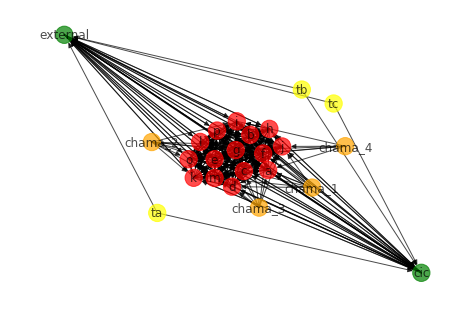

[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]
[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]
[{'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 30}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 60}}, {'N': 5, 'T': range(0, 100), 'M': {'drip_frequency': 90}}]


In [1]:
import math
import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from model.parts.supportingFunctions import *

pd.options.display.float_format = '{:.2f}'.format

%matplotlib inline
from tabulate import tabulate
from typing import Dict, List

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

# The following imports NEED to be in the exact order
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from model import economyconfig
from cadCAD import configs

exec_mode = ExecutionMode()

In [2]:
exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

i = 0
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    results[i] = {}
    results[i]['result'] = result
    i += 1


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f4a099f8890>, <cadCAD.configuration.Configuration object at 0x7f4a098ff450>, <cadCAD.configuration.Configuration object at 0x7f4a09937350>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f4a099f8890>, <cadCAD.configuration.Configuration object at 0x7f4a098ff450>, <cadCAD.configuration.Configuration object at 0x7f4a09937350>]


/home/aclarkdata/anaconda3/lib/python3.7/site-packages/cadCAD/utils/__init__.py:113: FutureWarning: The use of a dictionary to describe Partial State Update Blocks will be deprecated. Use a list instead.
  FutureWarning)


In [3]:
results[0]['result'].tail()

,network,KPIDemand,KPISpend,KPISpendOverDemand,VelocityOfMoney,startingBalance,30_day_spend,withdraw,outboundAgents,inboundAgents,operatorFiatBalance,operatorCICBalance,fundsInProcess,totalDistributedToAgents,totalMinted,totalBurned,run,substep,timestep
4000,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...",0.72,"{'a': -2.1724474214163934, 'b': 87.78588308123...","{'a': 564.306616354587, 'b': 2785.025646787363...",0,"[h, a, a, k, p, c, c, g, o, o, i, f, b, b]","[k, d, p, p, l, p, d, e, p, e, d, b, external, o]",16500,198500.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,4,100
4001,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...",0.72,"{'a': -2.1724474214163934, 'b': 87.78588308123...","{'a': 564.306616354587, 'b': 2785.025646787363...",0,"[h, a, a, k, p, c, c, g, o, o, i, f, b, b]","[k, d, p, p, l, p, d, e, p, e, d, b, external, o]",16500,198500.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,5,100
4002,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...","{'a': 0, 'b': 0, 'c': 0, 'd': 0, 'e': 0, 'f': ...",0.72,"{'a': -2.1724474214163934, 'b': 87.78588308123...","{'a': 564.306616354587, 'b': 2785.025646787363...",0,"[h, a, a, k, p, c, c, g, o, o, i, f, b, b]","[k, d, p, p, l, p, d, e, p, e, d, b, external, o]",16500,198500.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,6,100
4003,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 330, 'b': 590, 'c': 303, 'd': 0, 'e': 0,...","{'a': 352.69163522161693, 'b': 850.37760837978...","{'a': 1.0687625309745967, 'b': 1.4413179803047...",0.72,"{'a': -2.1724474214163934, 'b': 87.78588308123...","{'a': 564.306616354587, 'b': 2785.025646787363...",0,"[h, a, a, k, p, c, c, g, o, o, i, f, b, b]","[k, d, p, p, l, p, d, e, p, e, d, b, external, o]",16500,198500.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,7,100
4004,"(a, b, c, d, e, f, g, h, i, j, k, l, m, o, p, ...","{'a': 330, 'b': 590, 'c': 303, 'd': 0, 'e': 0,...","{'a': 352.69163522161693, 'b': 850.37760837978...","{'a': 1.0687625309745967, 'b': 1.4413179803047...",20.94,"{'a': -2.1724474214163934, 'b': 87.78588308123...","{'a': 564.306616354587, 'b': 2785.025646787363...",0,"[h, a, a, k, p, c, c, g, o, o, i, f, b, b]","[k, d, p, p, l, p, d, e, p, e, d, b, external, o]",16500,198500.00,"{'timestep': [], 'decision': [], 'cic': [], 's...",1500,0,0,5,8,100


In [4]:
for i in range(0,len(results)):
    results[i]['result']['agents'] = results[i]['result'].network.apply(lambda g: np.array([get_nodes_by_type(g,'Agent')][0]))
    results[i]['result']['agent_tokens'] = results[i]['result'].network.apply(lambda g: np.array([g.nodes[j]['tokens'] for j in get_nodes_by_type(g,'Agent')]))
    results[i]['result']['agent_native_currency'] = results[i]['result'].network.apply(lambda g: np.array([g.nodes[j]['native_currency'] for j in get_nodes_by_type(g,'Agent')]))
    # Create dataframe variables   
    tokens = []
    for j in results[i]['result'].index:
         tokens.append(sum(results[i]['result']['agent_tokens'][j]))

    results[i]['result']['AggregatedAgentCICHolding'] = tokens  

    currency = []
    for j in results[i]['result'].index:
         currency.append(sum(results[i]['result']['agent_native_currency'][j]))

    results[i]['result']['AggregatedAgentCurrencyHolding'] = currency  

    AggregatedSpend = []
    for j in results[i]['result'].index:
         AggregatedSpend.append(sum(results[i]['result']['KPISpend'][j].values()))

    results[i]['result']['AggregatedAgentSpend'] = AggregatedSpend   

    AggregatedDemand = []
    for j in results[i]['result'].index:
         AggregatedDemand.append(sum(results[i]['result']['KPIDemand'][j].values()))

    results[i]['result']['AggregatedAgentDemand'] = AggregatedDemand  


    AggregatedKPISpendOverDemand = []
    for j in results[i]['result'].index:
         AggregatedKPISpendOverDemand.append(sum(results[i]['result']['KPISpendOverDemand'][j].values()))

    results[i]['result']['AggregatedKPISpendOverDemand'] = AggregatedKPISpendOverDemand  


    AggregatedGapOfDemandMinusSpend = []
    for j in results[i]['result'].index:
         AggregatedGapOfDemandMinusSpend.append(sum(results[i]['result']['KPIDemand'][j].values())- sum(results[i]['result']['KPISpend'][j].values()))

    results[i]['result']['AggregatedGapOfDemandMinusSpend'] = AggregatedGapOfDemandMinusSpend  

In [9]:
params = [30,60,90]
swept = 'Red Cross Drip Frequency'
mean_df,median_df = param_dfs(results,params,swept)
median_df.head()

,timestep,VelocityOfMoney,operatorFiatBalance,operatorCICBalance,totalDistributedToAgents,totalMinted,totalBurned,run,substep,AggregatedAgentCICHolding,AggregatedAgentCurrencyHolding,AggregatedAgentSpend,AggregatedAgentDemand,AggregatedKPISpendOverDemand,AggregatedGapOfDemandMinusSpend,Red Cross Drip Frequency
0,1,10.51,4500,200000.00,0,0,0,3,8,6000.00,4869.00,1189.00,1389,3.20,138.00,30
1,2,9.72,4500,200000.00,0,0,0,3,8,6350.50,5219.50,1057.00,1057,4.00,0.00,30
2,3,19.57,4500,200000.00,0,0,0,3,8,6323.00,5192.00,2333.25,3275,7.14,941.75,30
3,4,15.67,4500,200000.00,0,0,0,3,8,6435.00,5304.00,1734.38,3737,6.85,789.75,30
4,5,20.01,4500,200000.00,0,0,0,3,8,6435.00,5304.00,2227.06,3140,6.99,498.25,30


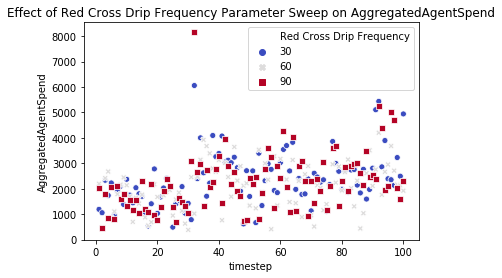

In [14]:
# plot of agent activity per timestep
param_plot(median_df,'timestep', 'AggregatedAgentSpend',swept)

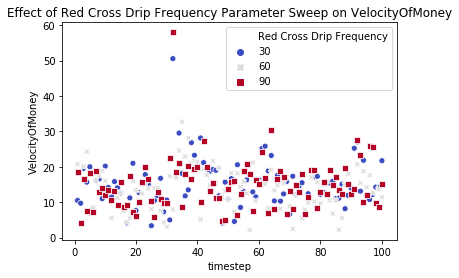

In [15]:
param_plot(median_df,'timestep', 'VelocityOfMoney',swept)

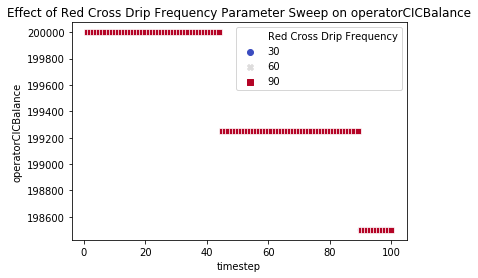

In [16]:
param_plot(median_df,'timestep', 'operatorCICBalance',swept)

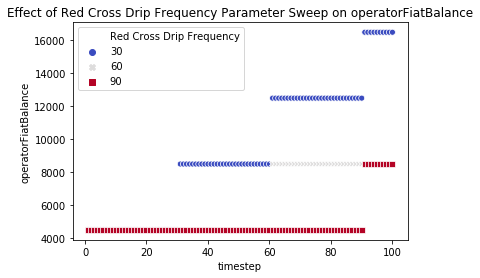

In [17]:
param_plot(median_df,'timestep', 'operatorFiatBalance',swept)

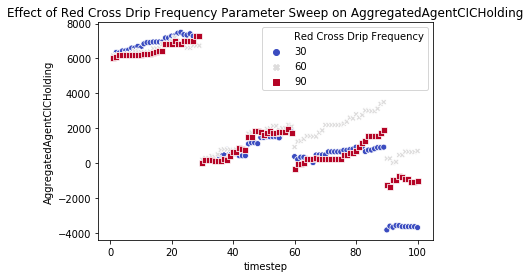

In [19]:
param_plot(median_df,'timestep', 'AggregatedAgentCICHolding',swept)

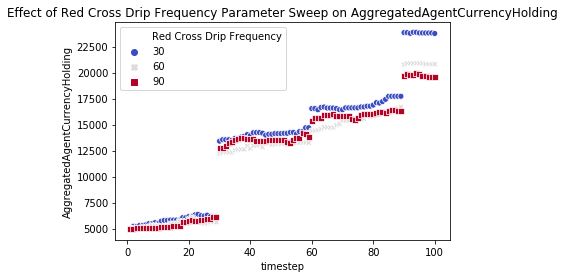

In [20]:
param_plot(median_df,'timestep', 'AggregatedAgentCurrencyHolding',swept)

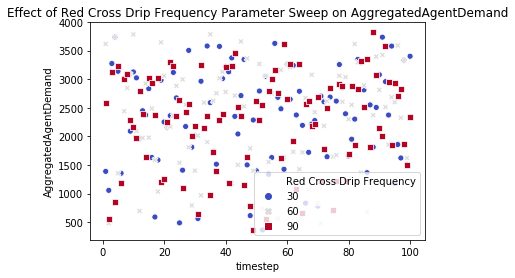

In [21]:
param_plot(median_df,'timestep', 'AggregatedAgentDemand',swept)